## 1. load data

In [14]:
from glob import glob 

path = glob("C:\\deeplearning\\birdclef-2022\\train_audio2\\")[0]
train_data = glob(path +"*\\*.ogg")
print(len(train_data))
print(train_data[0])

3000
C:\deeplearning\birdclef-2022\train_audio2\brnowl\XC112875.ogg


## 2. label data 

In [15]:
# 정답데이터 
import os 
import numpy as np

folder_name = os.listdir(path) 

y = np.empty((0, 1, ))

for index ,folder_name2 in enumerate(folder_name)  :
    for data  in  train_data :
        if folder_name2 in data :
            resp = np.array([index])
            resp = resp.reshape(1,1,)
            y = np.vstack((y,resp))

In [16]:
print(len(y))

3000


### 3. 데이터 분리 (훈련/검증) 

In [17]:
from sklearn.model_selection import train_test_split
import tensorflow as tf

# set_seed 가 적용 안되는것을 방지 하기 위해서 2개 설정 (tf 만했을때 정확도 차이있음) 
tf.random.set_seed(777)
np.random.seed(777)

x_train, x_val, y_train, y_val = train_test_split(train_data, y, test_size = 0.2, random_state=42)

print(len(x_train),len(x_val)) 
print(len(y_train),len(y_val)) 

2400 600
2400 600


In [18]:
# 정답데이터 원핫인코딩 
from tensorflow.keras.utils import to_categorical

train_labels = to_categorical(y_train)
val_labels = to_categorical(y_val)
print(val_labels)
print(len(train_labels)) # 14109 개의 훈련 정답데이터 
print(len(val_labels))  # 743 개의 검증 정답데이터

[[0. 0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0.]
 ...
 [0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0. 0.]]
2400
600


In [19]:
# x_train 의 정답인 y_train 로 만든 train_lables 로 가장 큰 값인 인덱스 설정하기  
index = np.argmax(train_labels, axis=1)

bird_name = np.array(folder_name)[index]

print(index)
print(len(index))

[1 1 0 ... 2 2 1]
2400


## wave 시각화 

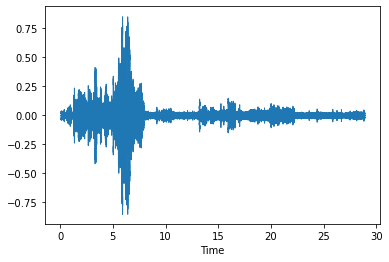

In [20]:
import matplotlib.pyplot as plt
import librosa.display

y, sr = librosa.load(x_train[0])
librosa.display.waveshow(y, sr = sr, x_axis = 'time')    

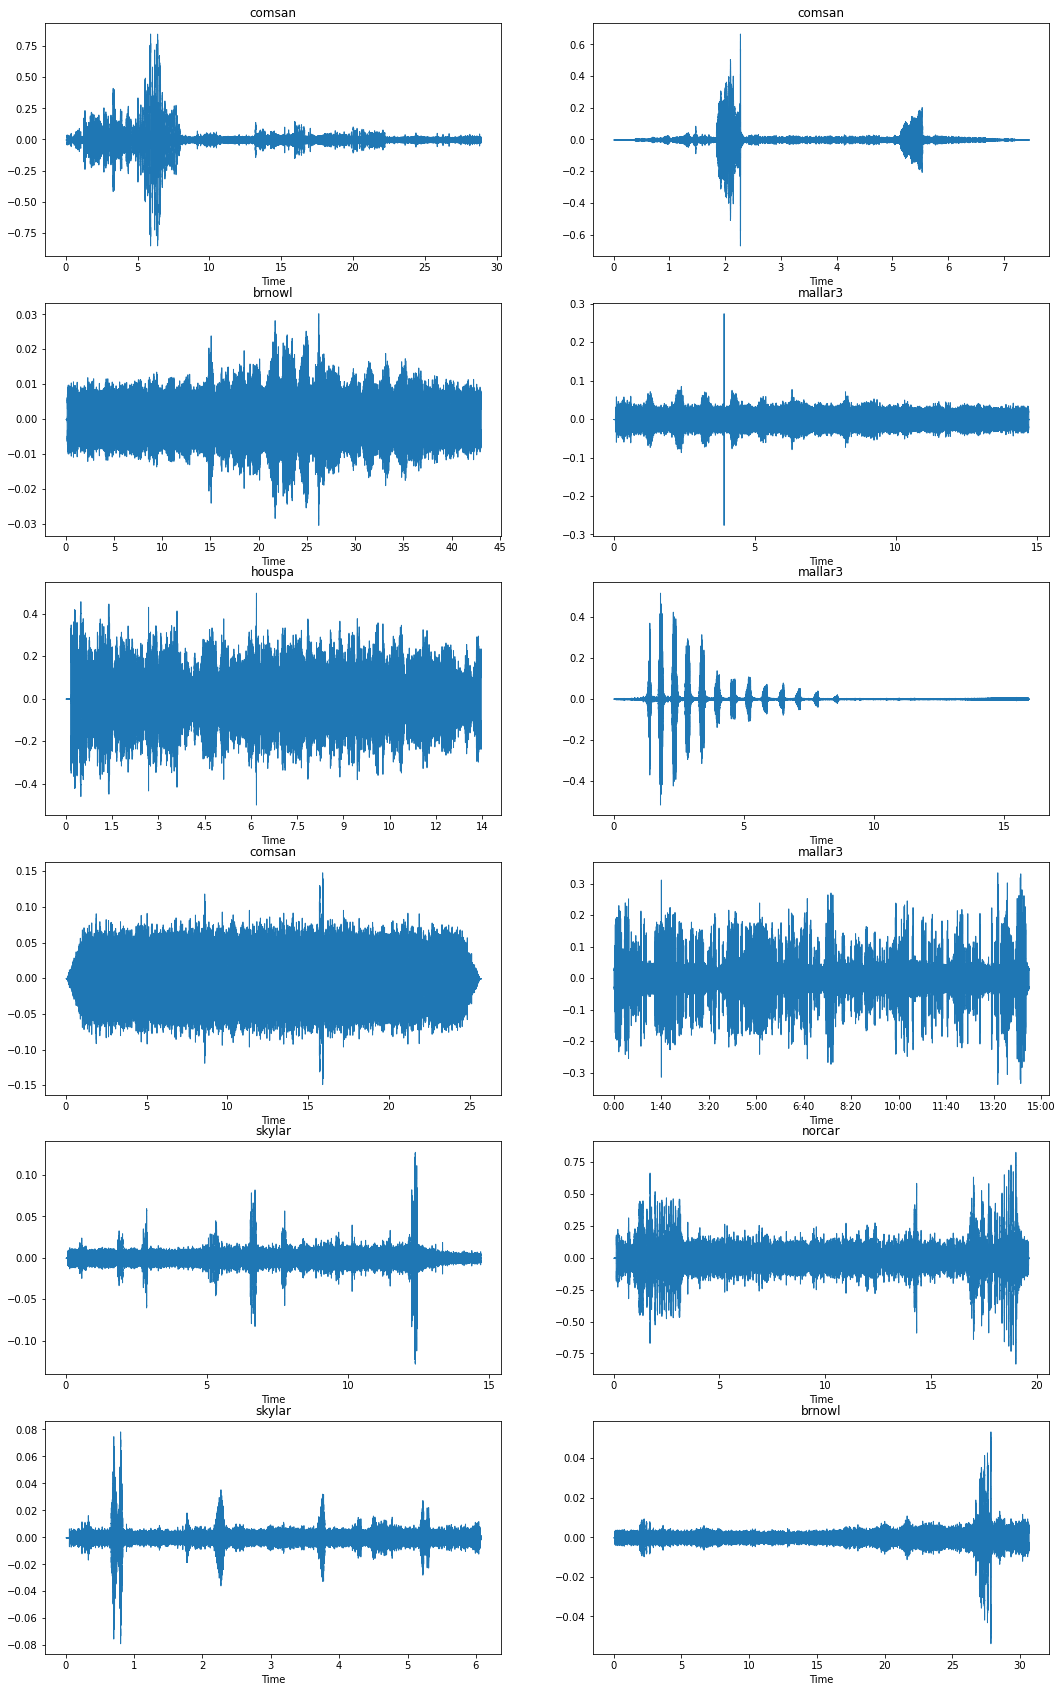

In [21]:
# 랜덤으로 추출한뒤 wave 시각화 
fig = plt.figure(figsize=(18,30))

for i in range(12) : 
    y, sr = librosa.load(x_train[i])
    index = np.argmax(train_labels, axis=1)
    bird_name = np.array(folder_name)[index]
    ax = fig.add_subplot(6,2,i+1)
    ax.set_title(bird_name[i])
    ax = librosa.display.waveshow(y, sr = sr, x_axis = 'time') 

## sample rate 수에 따른 시각화 차이 

In [22]:
y1, sr1 = librosa.load(x_train[0]) # sr 디폴트 값으로 출력하기 
y2, sr2 = librosa.load(x_train[0], sr=80000) # sr 80000 으로 주어 출력하기(일부러 극단적) 

print(sr1) # 22050
print(sr2) # 80000 
print(len(y1)) # 184897
print(len(y2)) # 670825

22050
80000
637157
2311680


(32000.0, 45000.0)

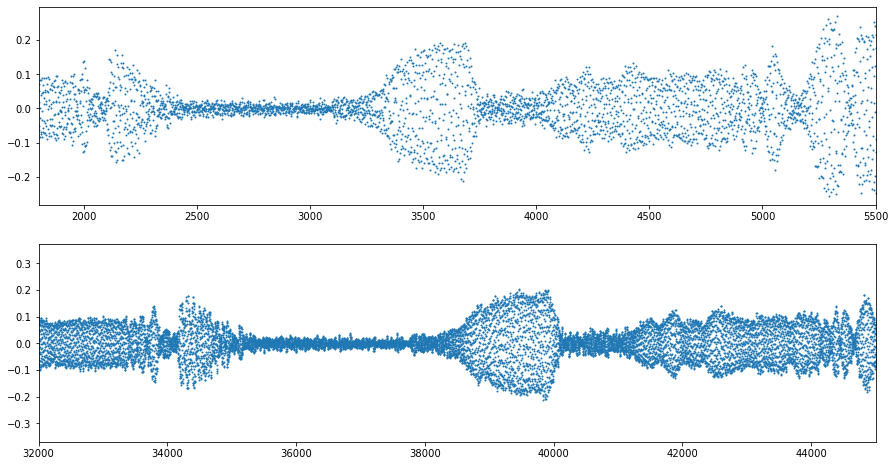

In [23]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(15,8))
ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(212)
ax1.scatter(range(len(y1[90000:100000])), y1[90000:100000], s=1)
ax2.scatter(range(len(y2[300000:400000])), y2[300000:400000], s=1)
ax1.set_xlim(1800,5500)
ax2.set_xlim(32000,45000)

### 진폭값 전체 추출 
- 진폭값으로 음성데이터 특징함수 추출 (신경망에 들어갈 것) 

In [24]:
# 1. x_train , x_test 전체정보 진폭값 출력하기 
import librosa 

def librosa_read_wav_files(wav_files) :
    if not isinstance(wav_files, list) : 
        wav_files = [wav_files] 
    return [librosa.load(f)[0] for f in wav_files] # 0 번째요소인 진폭 가져오기 

In [25]:
# 2. wav_rate 하나 생성하기
wav_rate = librosa.load(x_train[0])[1] # 훈련데이터의 첫번째 동물의 smple rate 값을 wave_rate 에 담기 
print(wav_rate) # 22050

22050


In [26]:
%%time
X_train = librosa_read_wav_files(x_train) #  진폭정보를 x_train 에 담음 
X_val  = librosa_read_wav_files(x_val)  #  진폭정보를 x_test 에 담음 

Wall time: 3h 20min 56s


## 신경망에 입력할 학습데이터 만들기

In [27]:
def extract_features(audio_samples, sample_rate):
    extracted_features = np.empty((0, 41, )) # 41개의 값을 받을 메모리를 할당하겠다는 뜻 (비어있는 리스트 만듦)
    
    #  리스트화 다시한번 확인 코드 
    if not isinstance(audio_samples, list):
        audio_samples = [audio_samples]
        
    for sample in audio_samples: # 진폭 데이터 리스트
        zero_cross_feat = librosa.feature.zero_crossing_rate(sample).mean() # 음성신호 파형이 중심축 0을 지나는 횟수를 평균낸것 
        mfccs = librosa.feature.mfcc(y=sample, sr=sample_rate, n_mfcc=40)
        mfccsscaled = np.mean(mfccs.T,axis=0)  # 각 주파수별 평균값을 구합니다.
        mfccsscaled = np.append(mfccsscaled, zero_cross_feat) # 주파수 40개에 대한 평균값 40 개와 zero_cross_feat 값을 가지고
        mfccsscaled = mfccsscaled.reshape(1, 41, ) # 41개의의 값을 학습데이터로 구성한
        extracted_features = np.vstack((extracted_features, mfccsscaled)) # 세로로 쌓아서 출력
    return extracted_features


In [29]:
%%time
X_val_features  = extract_features(X_val, wav_rate)
X_train_features = extract_features(X_train, wav_rate) 

Wall time: 5min 10s


In [123]:
print(type(y))

<class 'numpy.ndarray'>


#  1. 시각화 

Text(0.5, 1.0, 'Spectrogram')

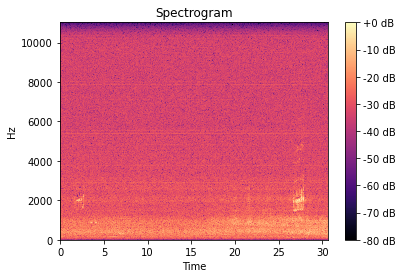

In [30]:
stft_result = librosa.stft(y, n_fft=4096, win_length = 4096, hop_length=1024)
D = np.abs(stft_result)
S_dB = librosa.power_to_db(D, ref=np.max)
librosa.display.specshow(S_dB, sr=sr, hop_length = 1024, y_axis='linear', x_axis='time')
plt.colorbar(format = '%+2.0f dB')
plt.title('Spectrogram')

# 시각화를 통해 알 수 있는것 
# 1. 시간의 3~4 범위 중 2000 hz (낮은소리범위) 의 작은 소리의 값이 특징인것으로 보인다. 

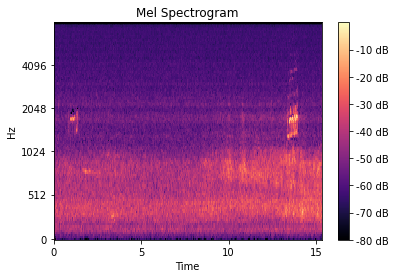

In [31]:
# mel spect 구하기 (차원 수 줄이기? )
mel_spect = librosa.feature.melspectrogram(y=y, sr=sr, n_fft=2048, hop_length=1024)
mel_spect = librosa.power_to_db(mel_spect, ref=np.max)
librosa.display.specshow(mel_spect, y_axis='mel', fmax=8000, x_axis='time');
plt.title('Mel Spectrogram');
plt.colorbar(format='%+2.0f dB');

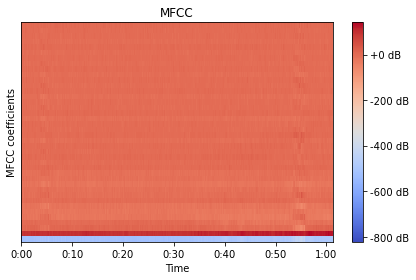

In [32]:
# cepstral 분석 (mfcc) 구하기
MFCCs = librosa.feature.mfcc(y = y, sr = sr, n_mfcc = 40) # 40 개보다 더 주어도 됨. 
librosa.display.specshow(MFCCs, x_axis = 'time', sr = sr, fmax = 8000, hop_length = 1024)

plt.colorbar(format = '%+2.0f dB');
plt.title('MFCC')
plt.ylabel("MFCC coefficients")
plt.tight_layout()

plt.show()

## 신경망 구성 (수동)  

In [95]:
from keras import layers
from keras import models
from keras import optimizers
from keras import losses
from keras.callbacks import ModelCheckpoint,EarlyStopping
from tensorflow.keras.layers import Dense ,Flatten  ,BatchNormalization,Dropout
from tensorflow.keras import backend as K

In [123]:
# 완전연결계층3층신경망
model = models.Sequential()
model.add(Flatten(input_shape=(41,)))
model.add(layers.Dense(800, activation = 'relu')) # 41개의입력뉴런으로flatten 시킨것입력받기
model.add(BatchNormalization())   
model.add(Dropout(0.1)) 
model.add(layers.Dense(700, activation = 'relu'))
model.add(BatchNormalization())   
#model.add(Dropout(0.1)) 
model.add(layers.Dense(500, activation = 'relu'))
model.add(BatchNormalization())   
#model.add(Dropout(0.3)) 
model.add(layers.Dense(300, activation = 'relu'))
model.add(BatchNormalization())  
#model.add(Dropout(0.1)) 
model.add(layers.Dense(200, activation = 'relu'))
model.add(BatchNormalization()) 
model.add(layers.Dense(6, activation = 'softmax')) # 출력층은 개와고양이를구분하므로 2개
#model.summary() # 모델의 설계도 보기

In [126]:
best_model_weights = 'C:\\deeplearning\\birdclef-2022\\weight\\bird_model.h5' # 모델저장위치

# 학습시킨 모델을 저장할 떄 가장 좋은 모델을 알아서 자동으로 생성
checkpoint = ModelCheckpoint(
    best_model_weights,
    monitor='val_accuracy',   # 테스트 데이터에 대한 정확도가 가장 좋은것으로 
    verbose=1,           # 모델이 저장되었으면 저장되었다고 화면에 표시 (1) 표시안할땐 (0) 
    save_best_only=True, # 모니터 되는중에 가장 좋은 모델 저장(early stopping 기능 필요x) 
    mode='max',          # 우리는 val_acc 로 했기 때문에 max 로 지정해야한다 만약 오차로 val_loss 로 했다면 오차는 작은게 좋으니 min 으로 하면 된다. 
    save_weights_only=False # true = 가중치만 저장된다. false = 가중치 + 모델도 저장 
   )

# 얼리스탑 기능 
estop = EarlyStopping(monitor ='val_accuracy' , patience = 20 , verbose =1 ) # 얼리스탑 기능 

callbacks = [checkpoint,estop]

model.compile(optimizer='adam',
              loss=losses.categorical_crossentropy,
              metrics=['accuracy'])
# 러닝레이트 
K.set_value(model.optimizer.learning_rate, 0.001)
#print("Learning Rate before second fit: ", model.optimizer.learning_rate.numpy() ) 


history = model.fit(
    X_train_features, # 훈련데이터(40개의 mel 값 +1 rodml zero_corossing_rate 의 평균값)
    train_labels,     # 원핫인코딩된 정답 
    validation_data = (X_val_features,val_labels),
    batch_size = 30,
    epochs = 200, 
    verbose = 1,
    callbacks=callbacks,
)

Epoch 1/200
78/80 [============================>.] - ETA: 0s - loss: 1.0902 - accuracy: 0.5889
Epoch 1: val_accuracy improved from -inf to 0.57167, saving model to C:\deeplearning\birdclef-2022\weight\bird_model.h5
80/80 [==============================] - 2s 17ms/step - loss: 1.0919 - accuracy: 0.5888 - val_loss: 1.1772 - val_accuracy: 0.5717
Epoch 2/200
79/80 [============================>.] - ETA: 0s - loss: 0.9541 - accuracy: 0.6338
Epoch 2: val_accuracy did not improve from 0.57167
80/80 [==============================] - 1s 10ms/step - loss: 0.9530 - accuracy: 0.6338 - val_loss: 1.2362 - val_accuracy: 0.5583
Epoch 3/200
80/80 [==============================] - ETA: 0s - loss: 0.9199 - accuracy: 0.6525
Epoch 3: val_accuracy did not improve from 0.57167
80/80 [==============================] - 1s 11ms/step - loss: 0.9199 - accuracy: 0.6525 - val_loss: 1.2532 - val_accuracy: 0.5550
Epoch 4/200
80/80 [==============================] - ETA: 0s - loss: 0.8511 - accuracy: 0.6758
Epoch 4:

Epoch 30/200
76/80 [===========================>..] - ETA: 0s - loss: 0.3474 - accuracy: 0.8680
Epoch 30: val_accuracy did not improve from 0.61167
80/80 [==============================] - 1s 11ms/step - loss: 0.3450 - accuracy: 0.8692 - val_loss: 1.7929 - val_accuracy: 0.5700
Epoch 31/200
76/80 [===========================>..] - ETA: 0s - loss: 0.3519 - accuracy: 0.8627
Epoch 31: val_accuracy did not improve from 0.61167
80/80 [==============================] - 1s 11ms/step - loss: 0.3516 - accuracy: 0.8633 - val_loss: 1.8196 - val_accuracy: 0.5717
Epoch 32/200
75/80 [===========================>..] - ETA: 0s - loss: 0.3292 - accuracy: 0.8693
Epoch 32: val_accuracy did not improve from 0.61167
80/80 [==============================] - 1s 11ms/step - loss: 0.3348 - accuracy: 0.8675 - val_loss: 1.8158 - val_accuracy: 0.5800
Epoch 33/200
76/80 [===========================>..] - ETA: 0s - loss: 0.3013 - accuracy: 0.8917
Epoch 33: val_accuracy did not improve from 0.61167
80/80 [===========

## 신경망 함수 

하이퍼파라미터들을 거의 다 밖으로 빼 놓았다. 


In [87]:
%%time

def create_model(params, X_train_features, train_labels,X_test_features, val_labels):
    ## 신경망 모델을 구성하기 위한 패키지 로드
    from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, BatchNormalization, Dropout
    from keras import models
    from keras import optimizers
    from keras import losses
    from keras.callbacks import ModelCheckpoint, EarlyStopping
    from tqdm.notebook import tqdm
    import pandas as pd
    from time import time
    from datetime import timedelta, datetime
    import os
    import random
    
    import absl.logging # 오류창 무시
    absl.logging.set_verbosity(absl.logging.ERROR)

    ## 저장 변수 선언
    result1 = []

    train_acc_list = []
    train_loss_list = []

    vali_acc_list = []
    vali_loss_list = []
    
    now = datetime.now() # 파일명에 시간을 기록하기 위해 선언하는 변수

    ## 모든 hyper parameter를 고려하여 반복문 실행
    for act, grad, pat, epo, bat, neu, lyr, nudir, bctn, drp, chkp, erstp in tqdm(params, desc = 'Progress... '):
        temp1 = neu
        temp2 = [] # 은닉층 뉴런 수 저장 변수

        start = time()

        ## 완전 연결계층으로 다층 신경망 구성
        # ※ 모든 무작위 값을 대비하기 위해 seed 값 지정
        tf.random.set_seed(777)
        np.random.seed(777)
        random.seed(777)

        model = models.Sequential()
        model.add(Flatten(input_shape = (41, ))) # 입력층

        for _ in range(lyr):
            model.add(Dense(temp1, activation = act)) # 은닉층

            if bctn:
                model.add(BatchNormalization()) # 배치 정규화 추가

            model.add(Dropout(drp)) # 드랍아웃 비율 적용
            temp2.append(temp1)
            temp1 = int(temp1 * nudir) # 뉴런 감소 적용

        model.add(Dense(6, activation = 'softmax')) # 출력층
        # print(model.summary()) # 현 모델 요약 표시(비활성화)

        if chkp: # 체크 포인트 사용시
            # ModelCheckpoint → 학습 시킨 모델을 저장할 때 가장 좋은 모델을 알아서 자동으로 생성 (참고글: https://deep-deep-deep.tistory.com/53)
            checkpoint = ModelCheckpoint(
                "C:/sound/portfolio", # 모델 저장 경로
                monitor = 'val_accuracy',  # 테스트 데이터에 대한 정확도를 기준으로 하여 가장 좋은 것으로 측정
                save_best_only = True,     # monitor 되고 있는 것 중에 가장 좋은 모델을 저장
                mode = 'max',              # monitor를 val_acc(정확도)로 했으면 클 수록 좋으므로 max로 설정하고 val_loss(오차)로 했으면 min으로 설정하는 것이 좋음
                save_weights_only = False, # 모델 레이어 및 weights 모두 저장
                verbose = 0,               # 모델이 저장되었으면 저장되었다고 표시(1), 표시 비활성화(0)
                # period = 1 # default로 수행하는 것이 효율이 좋았음
            )

        else:
            checkpoint = False

        if erstp: # Early Stopping 사용시
            estop = EarlyStopping(monitor = 'val_accuracy', patience = pat, verbose = 0) # EarlyStopping 기능(verbose = 1 → epochs 정지 표시)
            pat = int(pat)

        else:
            estop = False
            pat = None

        # 콜백 정의
        callbacks = [i for i in [checkpoint, estop] if i]

        ## 모델 설정(경사하강법, 오차함수를 정의)
        model.compile(
            optimizer = grad,
            loss = losses.categorical_crossentropy,
            metrics = ['accuracy'],
        )

        ## 모델 훈련
        hist = model.fit(
            X_train_features,
            train_labels,
            validation_data = (X_val_features, val_labels),
            epochs = epo,
            batch_size = bat,
            verbose = 0,
            callbacks = callbacks,
        )

        end = time()
        sec = (end - start)

        time_result = str(timedelta(seconds = sec)).split(".")[0]

        train_loss, train_acc = model.evaluate(X_train_features, train_labels, verbose = 0)
        #test_loss, test_acc   = model.evaluate(X_test_features, test_labels, verbose = 0)
        val_loss, val_acc     = model.evaluate(X_val_features, val_labels, verbose = 0)

        # 검증하여 출력한 최종 값
        train_acc_list.append(hist.history['accuracy']) # 훈련 데이터 정확도
        train_loss_list.append(hist.history['loss'])    # 훈련 데이터 오차율
        vali_acc_list.append(hist.history['val_accuracy']) # 검증 데이터 정확도
        vali_loss_list.append(hist.history['val_loss'])    # 검증 데이터 오차율

        final_epochs = len(train_acc_list[-1])

        result1.append((
            train_loss, train_acc, 
            #test_loss, test_acc, 
            val_loss, val_acc,
            act, grad, pat, epo, bat,
            final_epochs, temp2, lyr, nudir, bctn, 
            drp, chkp, erstp, time_result
        ))

    result2 = pd.DataFrame(result1)
    result2.columns = [
        'Train Loss', 'Train Accuracy', 
        #'Test Loss','Test Accuracy', 
        'Progress Valid Loss', 'Progress Valid Accuracy',
        'Activation', 'Gradient', 'Patience', 'Epochs', 'Batch Size',
        'Final Epochs', 'Neurons', 'Layers', 'Neurons Divide Rate', 'Batch Normalization', 
        'Dropout Rate', 'Check Point', 'Early Stopping', 'Time'
    ]
    
    # 경로지정(※주의사항: csv파일을 연 상태일 경우 권한 거부되어 파일 저장이 안되므로 절대 작업중에 열지 말 것)
    path1 = "C:/sound/portfolio/"
    
    file_list = os.listdir(path1)
    file_name = "%s_result.csv"%(now.strftime("%Y-%m-%d")) # 현재 날짜 저장
    
    path2 = "%s/%s"%(path1, file_name)
    
    if file_name in file_list: # 해당 경로의 파일 검사
        result2.to_csv(path2, mode = 'a', header = False, index = True) # 파일이 있을 시 이어쓰기로 표 저장
    else:
        result2.to_csv(path2, mode = 'a', index = True) # 파일이 없을 시 최초 생성
    
    return result1, result2, train_acc_list, train_loss_list, vali_acc_list, vali_loss_list, model

Wall time: 0 ns


In [127]:
%%time

################ Hyper parameters ################

activation = ['ReLU','sigmoid','tanh']  # 활성화 함수
gradient = ['Adam','RMSProp','Adagrad'] # 경사하강법
epochs = [200]         # epochs
batch_size = [20]      # batch_size(사용 안할 시 None으로 지정)
neurons = [900]        # 합성곱, 은닉층 뉴런 수
layers = [5]           # 합성곱, 은닉층 수
neu_div_rate = [1, 0.9]   # 뉴런 수 감소 비율
batchnorm = [True]     # 배치 정규화 활성화 여부
dropout = [0]        # 드랍아웃 비율
patiences = [15]       # EarlyStopping 활성화 시 기준되는 값이 연속으로 몇 번 이상 향상되지 않을 때 종료시킬 변수 값
chk_point = [True]     # check point 활성화 여부
early_stop = [True]    # Early Stopping 기능 활성화 여부

##################################################

## 중복순열을 이용하여 모든 경우의 수 계산하여 tuple에 담음
from itertools import product

params = tuple(product(activation, gradient, patiences, epochs, batch_size, neurons, layers, neu_div_rate, batchnorm, dropout, chk_point, early_stop))

res1, res2, train_acc, train_loss, vali_acc, vali_loss, model = create_model(params, 
                                                                             X_train_features, 
                                                                             train_labels, 
                                                                             X_val_features,
                                                                             val_labels)
                                                                            
res2

Progress... :   0%|          | 0/18 [00:00<?, ?it/s]

INFO:tensorflow:Assets written to: C:/sound\portfolio\assets


INFO:tensorflow:Assets written to: C:/sound\portfolio\assets


INFO:tensorflow:Assets written to: C:/sound\portfolio\assets


INFO:tensorflow:Assets written to: C:/sound\portfolio\assets


INFO:tensorflow:Assets written to: C:/sound\portfolio\assets


INFO:tensorflow:Assets written to: C:/sound\portfolio\assets


INFO:tensorflow:Assets written to: C:/sound\portfolio\assets


INFO:tensorflow:Assets written to: C:/sound\portfolio\assets


INFO:tensorflow:Assets written to: C:/sound\portfolio\assets


INFO:tensorflow:Assets written to: C:/sound\portfolio\assets


INFO:tensorflow:Assets written to: C:/sound\portfolio\assets


INFO:tensorflow:Assets written to: C:/sound\portfolio\assets


INFO:tensorflow:Assets written to: C:/sound\portfolio\assets


INFO:tensorflow:Assets written to: C:/sound\portfolio\assets


INFO:tensorflow:Assets written to: C:/sound\portfolio\assets


INFO:tensorflow:Assets written to: C:/sound\portfolio\assets


INFO:tensorflow:Assets written to: C:/sound\portfolio\assets


INFO:tensorflow:Assets written to: C:/sound\portfolio\assets


INFO:tensorflow:Assets written to: C:/sound\portfolio\assets


INFO:tensorflow:Assets written to: C:/sound\portfolio\assets


INFO:tensorflow:Assets written to: C:/sound\portfolio\assets


INFO:tensorflow:Assets written to: C:/sound\portfolio\assets


INFO:tensorflow:Assets written to: C:/sound\portfolio\assets


INFO:tensorflow:Assets written to: C:/sound\portfolio\assets


INFO:tensorflow:Assets written to: C:/sound\portfolio\assets


INFO:tensorflow:Assets written to: C:/sound\portfolio\assets


INFO:tensorflow:Assets written to: C:/sound\portfolio\assets


INFO:tensorflow:Assets written to: C:/sound\portfolio\assets


INFO:tensorflow:Assets written to: C:/sound\portfolio\assets


INFO:tensorflow:Assets written to: C:/sound\portfolio\assets


INFO:tensorflow:Assets written to: C:/sound\portfolio\assets


INFO:tensorflow:Assets written to: C:/sound\portfolio\assets


INFO:tensorflow:Assets written to: C:/sound\portfolio\assets


INFO:tensorflow:Assets written to: C:/sound\portfolio\assets


INFO:tensorflow:Assets written to: C:/sound\portfolio\assets


INFO:tensorflow:Assets written to: C:/sound\portfolio\assets


INFO:tensorflow:Assets written to: C:/sound\portfolio\assets


INFO:tensorflow:Assets written to: C:/sound\portfolio\assets


INFO:tensorflow:Assets written to: C:/sound\portfolio\assets


INFO:tensorflow:Assets written to: C:/sound\portfolio\assets


INFO:tensorflow:Assets written to: C:/sound\portfolio\assets


INFO:tensorflow:Assets written to: C:/sound\portfolio\assets


INFO:tensorflow:Assets written to: C:/sound\portfolio\assets


INFO:tensorflow:Assets written to: C:/sound\portfolio\assets


INFO:tensorflow:Assets written to: C:/sound\portfolio\assets


INFO:tensorflow:Assets written to: C:/sound\portfolio\assets


INFO:tensorflow:Assets written to: C:/sound\portfolio\assets


INFO:tensorflow:Assets written to: C:/sound\portfolio\assets


INFO:tensorflow:Assets written to: C:/sound\portfolio\assets


INFO:tensorflow:Assets written to: C:/sound\portfolio\assets


INFO:tensorflow:Assets written to: C:/sound\portfolio\assets


INFO:tensorflow:Assets written to: C:/sound\portfolio\assets


INFO:tensorflow:Assets written to: C:/sound\portfolio\assets


INFO:tensorflow:Assets written to: C:/sound\portfolio\assets


INFO:tensorflow:Assets written to: C:/sound\portfolio\assets


INFO:tensorflow:Assets written to: C:/sound\portfolio\assets


INFO:tensorflow:Assets written to: C:/sound\portfolio\assets


INFO:tensorflow:Assets written to: C:/sound\portfolio\assets


INFO:tensorflow:Assets written to: C:/sound\portfolio\assets


INFO:tensorflow:Assets written to: C:/sound\portfolio\assets


INFO:tensorflow:Assets written to: C:/sound\portfolio\assets


INFO:tensorflow:Assets written to: C:/sound\portfolio\assets


INFO:tensorflow:Assets written to: C:/sound\portfolio\assets


INFO:tensorflow:Assets written to: C:/sound\portfolio\assets


INFO:tensorflow:Assets written to: C:/sound\portfolio\assets


INFO:tensorflow:Assets written to: C:/sound\portfolio\assets


INFO:tensorflow:Assets written to: C:/sound\portfolio\assets


INFO:tensorflow:Assets written to: C:/sound\portfolio\assets


INFO:tensorflow:Assets written to: C:/sound\portfolio\assets


INFO:tensorflow:Assets written to: C:/sound\portfolio\assets


INFO:tensorflow:Assets written to: C:/sound\portfolio\assets


INFO:tensorflow:Assets written to: C:/sound\portfolio\assets


INFO:tensorflow:Assets written to: C:/sound\portfolio\assets


INFO:tensorflow:Assets written to: C:/sound\portfolio\assets


INFO:tensorflow:Assets written to: C:/sound\portfolio\assets


INFO:tensorflow:Assets written to: C:/sound\portfolio\assets


INFO:tensorflow:Assets written to: C:/sound\portfolio\assets


INFO:tensorflow:Assets written to: C:/sound\portfolio\assets


INFO:tensorflow:Assets written to: C:/sound\portfolio\assets


INFO:tensorflow:Assets written to: C:/sound\portfolio\assets


INFO:tensorflow:Assets written to: C:/sound\portfolio\assets


INFO:tensorflow:Assets written to: C:/sound\portfolio\assets


INFO:tensorflow:Assets written to: C:/sound\portfolio\assets


INFO:tensorflow:Assets written to: C:/sound\portfolio\assets


INFO:tensorflow:Assets written to: C:/sound\portfolio\assets


INFO:tensorflow:Assets written to: C:/sound\portfolio\assets


INFO:tensorflow:Assets written to: C:/sound\portfolio\assets


INFO:tensorflow:Assets written to: C:/sound\portfolio\assets


INFO:tensorflow:Assets written to: C:/sound\portfolio\assets


INFO:tensorflow:Assets written to: C:/sound\portfolio\assets


INFO:tensorflow:Assets written to: C:/sound\portfolio\assets


INFO:tensorflow:Assets written to: C:/sound\portfolio\assets


INFO:tensorflow:Assets written to: C:/sound\portfolio\assets


INFO:tensorflow:Assets written to: C:/sound\portfolio\assets


INFO:tensorflow:Assets written to: C:/sound\portfolio\assets


INFO:tensorflow:Assets written to: C:/sound\portfolio\assets


INFO:tensorflow:Assets written to: C:/sound\portfolio\assets


INFO:tensorflow:Assets written to: C:/sound\portfolio\assets


INFO:tensorflow:Assets written to: C:/sound\portfolio\assets


INFO:tensorflow:Assets written to: C:/sound\portfolio\assets


INFO:tensorflow:Assets written to: C:/sound\portfolio\assets


INFO:tensorflow:Assets written to: C:/sound\portfolio\assets


INFO:tensorflow:Assets written to: C:/sound\portfolio\assets


INFO:tensorflow:Assets written to: C:/sound\portfolio\assets


INFO:tensorflow:Assets written to: C:/sound\portfolio\assets


INFO:tensorflow:Assets written to: C:/sound\portfolio\assets


INFO:tensorflow:Assets written to: C:/sound\portfolio\assets


INFO:tensorflow:Assets written to: C:/sound\portfolio\assets


INFO:tensorflow:Assets written to: C:/sound\portfolio\assets


INFO:tensorflow:Assets written to: C:/sound\portfolio\assets


INFO:tensorflow:Assets written to: C:/sound\portfolio\assets


INFO:tensorflow:Assets written to: C:/sound\portfolio\assets


INFO:tensorflow:Assets written to: C:/sound\portfolio\assets


INFO:tensorflow:Assets written to: C:/sound\portfolio\assets


INFO:tensorflow:Assets written to: C:/sound\portfolio\assets


INFO:tensorflow:Assets written to: C:/sound\portfolio\assets


INFO:tensorflow:Assets written to: C:/sound\portfolio\assets


INFO:tensorflow:Assets written to: C:/sound\portfolio\assets


INFO:tensorflow:Assets written to: C:/sound\portfolio\assets


INFO:tensorflow:Assets written to: C:/sound\portfolio\assets


INFO:tensorflow:Assets written to: C:/sound\portfolio\assets


INFO:tensorflow:Assets written to: C:/sound\portfolio\assets


INFO:tensorflow:Assets written to: C:/sound\portfolio\assets


INFO:tensorflow:Assets written to: C:/sound\portfolio\assets


INFO:tensorflow:Assets written to: C:/sound\portfolio\assets


INFO:tensorflow:Assets written to: C:/sound\portfolio\assets


INFO:tensorflow:Assets written to: C:/sound\portfolio\assets


INFO:tensorflow:Assets written to: C:/sound\portfolio\assets


INFO:tensorflow:Assets written to: C:/sound\portfolio\assets


INFO:tensorflow:Assets written to: C:/sound\portfolio\assets


INFO:tensorflow:Assets written to: C:/sound\portfolio\assets


INFO:tensorflow:Assets written to: C:/sound\portfolio\assets


INFO:tensorflow:Assets written to: C:/sound\portfolio\assets


INFO:tensorflow:Assets written to: C:/sound\portfolio\assets


INFO:tensorflow:Assets written to: C:/sound\portfolio\assets


INFO:tensorflow:Assets written to: C:/sound\portfolio\assets


INFO:tensorflow:Assets written to: C:/sound\portfolio\assets


INFO:tensorflow:Assets written to: C:/sound\portfolio\assets


INFO:tensorflow:Assets written to: C:/sound\portfolio\assets


INFO:tensorflow:Assets written to: C:/sound\portfolio\assets


INFO:tensorflow:Assets written to: C:/sound\portfolio\assets


INFO:tensorflow:Assets written to: C:/sound\portfolio\assets


INFO:tensorflow:Assets written to: C:/sound\portfolio\assets


INFO:tensorflow:Assets written to: C:/sound\portfolio\assets


INFO:tensorflow:Assets written to: C:/sound\portfolio\assets


INFO:tensorflow:Assets written to: C:/sound\portfolio\assets


INFO:tensorflow:Assets written to: C:/sound\portfolio\assets


INFO:tensorflow:Assets written to: C:/sound\portfolio\assets


INFO:tensorflow:Assets written to: C:/sound\portfolio\assets


INFO:tensorflow:Assets written to: C:/sound\portfolio\assets


INFO:tensorflow:Assets written to: C:/sound\portfolio\assets


INFO:tensorflow:Assets written to: C:/sound\portfolio\assets


INFO:tensorflow:Assets written to: C:/sound\portfolio\assets


INFO:tensorflow:Assets written to: C:/sound\portfolio\assets


INFO:tensorflow:Assets written to: C:/sound\portfolio\assets


INFO:tensorflow:Assets written to: C:/sound\portfolio\assets


INFO:tensorflow:Assets written to: C:/sound\portfolio\assets


INFO:tensorflow:Assets written to: C:/sound\portfolio\assets


INFO:tensorflow:Assets written to: C:/sound\portfolio\assets


INFO:tensorflow:Assets written to: C:/sound\portfolio\assets


INFO:tensorflow:Assets written to: C:/sound\portfolio\assets


INFO:tensorflow:Assets written to: C:/sound\portfolio\assets


INFO:tensorflow:Assets written to: C:/sound\portfolio\assets


INFO:tensorflow:Assets written to: C:/sound\portfolio\assets


INFO:tensorflow:Assets written to: C:/sound\portfolio\assets


INFO:tensorflow:Assets written to: C:/sound\portfolio\assets


INFO:tensorflow:Assets written to: C:/sound\portfolio\assets


INFO:tensorflow:Assets written to: C:/sound\portfolio\assets


INFO:tensorflow:Assets written to: C:/sound\portfolio\assets


INFO:tensorflow:Assets written to: C:/sound\portfolio\assets


INFO:tensorflow:Assets written to: C:/sound\portfolio\assets


INFO:tensorflow:Assets written to: C:/sound\portfolio\assets


INFO:tensorflow:Assets written to: C:/sound\portfolio\assets


INFO:tensorflow:Assets written to: C:/sound\portfolio\assets


INFO:tensorflow:Assets written to: C:/sound\portfolio\assets


INFO:tensorflow:Assets written to: C:/sound\portfolio\assets


INFO:tensorflow:Assets written to: C:/sound\portfolio\assets


INFO:tensorflow:Assets written to: C:/sound\portfolio\assets


INFO:tensorflow:Assets written to: C:/sound\portfolio\assets


INFO:tensorflow:Assets written to: C:/sound\portfolio\assets


INFO:tensorflow:Assets written to: C:/sound\portfolio\assets


INFO:tensorflow:Assets written to: C:/sound\portfolio\assets


INFO:tensorflow:Assets written to: C:/sound\portfolio\assets


INFO:tensorflow:Assets written to: C:/sound\portfolio\assets


INFO:tensorflow:Assets written to: C:/sound\portfolio\assets


INFO:tensorflow:Assets written to: C:/sound\portfolio\assets


INFO:tensorflow:Assets written to: C:/sound\portfolio\assets


INFO:tensorflow:Assets written to: C:/sound\portfolio\assets


INFO:tensorflow:Assets written to: C:/sound\portfolio\assets


INFO:tensorflow:Assets written to: C:/sound\portfolio\assets


INFO:tensorflow:Assets written to: C:/sound\portfolio\assets


INFO:tensorflow:Assets written to: C:/sound\portfolio\assets


INFO:tensorflow:Assets written to: C:/sound\portfolio\assets


INFO:tensorflow:Assets written to: C:/sound\portfolio\assets


INFO:tensorflow:Assets written to: C:/sound\portfolio\assets


INFO:tensorflow:Assets written to: C:/sound\portfolio\assets


INFO:tensorflow:Assets written to: C:/sound\portfolio\assets


INFO:tensorflow:Assets written to: C:/sound\portfolio\assets


INFO:tensorflow:Assets written to: C:/sound\portfolio\assets


INFO:tensorflow:Assets written to: C:/sound\portfolio\assets


INFO:tensorflow:Assets written to: C:/sound\portfolio\assets


INFO:tensorflow:Assets written to: C:/sound\portfolio\assets


INFO:tensorflow:Assets written to: C:/sound\portfolio\assets


INFO:tensorflow:Assets written to: C:/sound\portfolio\assets


INFO:tensorflow:Assets written to: C:/sound\portfolio\assets


INFO:tensorflow:Assets written to: C:/sound\portfolio\assets


INFO:tensorflow:Assets written to: C:/sound\portfolio\assets


INFO:tensorflow:Assets written to: C:/sound\portfolio\assets


INFO:tensorflow:Assets written to: C:/sound\portfolio\assets


INFO:tensorflow:Assets written to: C:/sound\portfolio\assets


INFO:tensorflow:Assets written to: C:/sound\portfolio\assets


INFO:tensorflow:Assets written to: C:/sound\portfolio\assets


INFO:tensorflow:Assets written to: C:/sound\portfolio\assets


INFO:tensorflow:Assets written to: C:/sound\portfolio\assets


INFO:tensorflow:Assets written to: C:/sound\portfolio\assets


INFO:tensorflow:Assets written to: C:/sound\portfolio\assets


INFO:tensorflow:Assets written to: C:/sound\portfolio\assets


INFO:tensorflow:Assets written to: C:/sound\portfolio\assets


INFO:tensorflow:Assets written to: C:/sound\portfolio\assets


INFO:tensorflow:Assets written to: C:/sound\portfolio\assets


INFO:tensorflow:Assets written to: C:/sound\portfolio\assets


INFO:tensorflow:Assets written to: C:/sound\portfolio\assets


INFO:tensorflow:Assets written to: C:/sound\portfolio\assets


INFO:tensorflow:Assets written to: C:/sound\portfolio\assets


INFO:tensorflow:Assets written to: C:/sound\portfolio\assets


INFO:tensorflow:Assets written to: C:/sound\portfolio\assets


INFO:tensorflow:Assets written to: C:/sound\portfolio\assets


INFO:tensorflow:Assets written to: C:/sound\portfolio\assets


INFO:tensorflow:Assets written to: C:/sound\portfolio\assets


INFO:tensorflow:Assets written to: C:/sound\portfolio\assets


INFO:tensorflow:Assets written to: C:/sound\portfolio\assets


INFO:tensorflow:Assets written to: C:/sound\portfolio\assets


INFO:tensorflow:Assets written to: C:/sound\portfolio\assets


INFO:tensorflow:Assets written to: C:/sound\portfolio\assets


INFO:tensorflow:Assets written to: C:/sound\portfolio\assets


INFO:tensorflow:Assets written to: C:/sound\portfolio\assets


INFO:tensorflow:Assets written to: C:/sound\portfolio\assets


INFO:tensorflow:Assets written to: C:/sound\portfolio\assets


INFO:tensorflow:Assets written to: C:/sound\portfolio\assets


INFO:tensorflow:Assets written to: C:/sound\portfolio\assets


INFO:tensorflow:Assets written to: C:/sound\portfolio\assets


INFO:tensorflow:Assets written to: C:/sound\portfolio\assets


INFO:tensorflow:Assets written to: C:/sound\portfolio\assets


INFO:tensorflow:Assets written to: C:/sound\portfolio\assets


INFO:tensorflow:Assets written to: C:/sound\portfolio\assets


INFO:tensorflow:Assets written to: C:/sound\portfolio\assets


INFO:tensorflow:Assets written to: C:/sound\portfolio\assets


INFO:tensorflow:Assets written to: C:/sound\portfolio\assets


INFO:tensorflow:Assets written to: C:/sound\portfolio\assets


INFO:tensorflow:Assets written to: C:/sound\portfolio\assets


INFO:tensorflow:Assets written to: C:/sound\portfolio\assets


INFO:tensorflow:Assets written to: C:/sound\portfolio\assets


INFO:tensorflow:Assets written to: C:/sound\portfolio\assets


INFO:tensorflow:Assets written to: C:/sound\portfolio\assets


INFO:tensorflow:Assets written to: C:/sound\portfolio\assets


INFO:tensorflow:Assets written to: C:/sound\portfolio\assets


INFO:tensorflow:Assets written to: C:/sound\portfolio\assets


INFO:tensorflow:Assets written to: C:/sound\portfolio\assets


INFO:tensorflow:Assets written to: C:/sound\portfolio\assets


INFO:tensorflow:Assets written to: C:/sound\portfolio\assets


INFO:tensorflow:Assets written to: C:/sound\portfolio\assets


INFO:tensorflow:Assets written to: C:/sound\portfolio\assets


INFO:tensorflow:Assets written to: C:/sound\portfolio\assets


INFO:tensorflow:Assets written to: C:/sound\portfolio\assets


INFO:tensorflow:Assets written to: C:/sound\portfolio\assets


INFO:tensorflow:Assets written to: C:/sound\portfolio\assets


INFO:tensorflow:Assets written to: C:/sound\portfolio\assets


INFO:tensorflow:Assets written to: C:/sound\portfolio\assets


INFO:tensorflow:Assets written to: C:/sound\portfolio\assets


INFO:tensorflow:Assets written to: C:/sound\portfolio\assets


INFO:tensorflow:Assets written to: C:/sound\portfolio\assets


INFO:tensorflow:Assets written to: C:/sound\portfolio\assets


INFO:tensorflow:Assets written to: C:/sound\portfolio\assets


INFO:tensorflow:Assets written to: C:/sound\portfolio\assets


INFO:tensorflow:Assets written to: C:/sound\portfolio\assets


INFO:tensorflow:Assets written to: C:/sound\portfolio\assets


INFO:tensorflow:Assets written to: C:/sound\portfolio\assets


INFO:tensorflow:Assets written to: C:/sound\portfolio\assets


INFO:tensorflow:Assets written to: C:/sound\portfolio\assets


INFO:tensorflow:Assets written to: C:/sound\portfolio\assets


INFO:tensorflow:Assets written to: C:/sound\portfolio\assets


INFO:tensorflow:Assets written to: C:/sound\portfolio\assets


INFO:tensorflow:Assets written to: C:/sound\portfolio\assets


INFO:tensorflow:Assets written to: C:/sound\portfolio\assets


INFO:tensorflow:Assets written to: C:/sound\portfolio\assets


INFO:tensorflow:Assets written to: C:/sound\portfolio\assets


INFO:tensorflow:Assets written to: C:/sound\portfolio\assets


INFO:tensorflow:Assets written to: C:/sound\portfolio\assets


INFO:tensorflow:Assets written to: C:/sound\portfolio\assets


INFO:tensorflow:Assets written to: C:/sound\portfolio\assets


INFO:tensorflow:Assets written to: C:/sound\portfolio\assets


INFO:tensorflow:Assets written to: C:/sound\portfolio\assets


INFO:tensorflow:Assets written to: C:/sound\portfolio\assets


INFO:tensorflow:Assets written to: C:/sound\portfolio\assets


INFO:tensorflow:Assets written to: C:/sound\portfolio\assets


INFO:tensorflow:Assets written to: C:/sound\portfolio\assets


INFO:tensorflow:Assets written to: C:/sound\portfolio\assets


INFO:tensorflow:Assets written to: C:/sound\portfolio\assets


INFO:tensorflow:Assets written to: C:/sound\portfolio\assets


INFO:tensorflow:Assets written to: C:/sound\portfolio\assets


INFO:tensorflow:Assets written to: C:/sound\portfolio\assets


INFO:tensorflow:Assets written to: C:/sound\portfolio\assets


INFO:tensorflow:Assets written to: C:/sound\portfolio\assets


INFO:tensorflow:Assets written to: C:/sound\portfolio\assets


INFO:tensorflow:Assets written to: C:/sound\portfolio\assets


INFO:tensorflow:Assets written to: C:/sound\portfolio\assets


INFO:tensorflow:Assets written to: C:/sound\portfolio\assets


INFO:tensorflow:Assets written to: C:/sound\portfolio\assets


INFO:tensorflow:Assets written to: C:/sound\portfolio\assets


INFO:tensorflow:Assets written to: C:/sound\portfolio\assets


INFO:tensorflow:Assets written to: C:/sound\portfolio\assets


INFO:tensorflow:Assets written to: C:/sound\portfolio\assets


INFO:tensorflow:Assets written to: C:/sound\portfolio\assets


INFO:tensorflow:Assets written to: C:/sound\portfolio\assets


INFO:tensorflow:Assets written to: C:/sound\portfolio\assets


INFO:tensorflow:Assets written to: C:/sound\portfolio\assets


INFO:tensorflow:Assets written to: C:/sound\portfolio\assets


INFO:tensorflow:Assets written to: C:/sound\portfolio\assets


INFO:tensorflow:Assets written to: C:/sound\portfolio\assets


INFO:tensorflow:Assets written to: C:/sound\portfolio\assets


INFO:tensorflow:Assets written to: C:/sound\portfolio\assets


INFO:tensorflow:Assets written to: C:/sound\portfolio\assets


INFO:tensorflow:Assets written to: C:/sound\portfolio\assets


INFO:tensorflow:Assets written to: C:/sound\portfolio\assets


INFO:tensorflow:Assets written to: C:/sound\portfolio\assets


INFO:tensorflow:Assets written to: C:/sound\portfolio\assets


INFO:tensorflow:Assets written to: C:/sound\portfolio\assets


INFO:tensorflow:Assets written to: C:/sound\portfolio\assets


INFO:tensorflow:Assets written to: C:/sound\portfolio\assets


INFO:tensorflow:Assets written to: C:/sound\portfolio\assets


INFO:tensorflow:Assets written to: C:/sound\portfolio\assets


INFO:tensorflow:Assets written to: C:/sound\portfolio\assets


INFO:tensorflow:Assets written to: C:/sound\portfolio\assets


INFO:tensorflow:Assets written to: C:/sound\portfolio\assets


INFO:tensorflow:Assets written to: C:/sound\portfolio\assets


INFO:tensorflow:Assets written to: C:/sound\portfolio\assets


INFO:tensorflow:Assets written to: C:/sound\portfolio\assets


INFO:tensorflow:Assets written to: C:/sound\portfolio\assets


INFO:tensorflow:Assets written to: C:/sound\portfolio\assets


INFO:tensorflow:Assets written to: C:/sound\portfolio\assets


INFO:tensorflow:Assets written to: C:/sound\portfolio\assets


INFO:tensorflow:Assets written to: C:/sound\portfolio\assets


INFO:tensorflow:Assets written to: C:/sound\portfolio\assets


INFO:tensorflow:Assets written to: C:/sound\portfolio\assets


INFO:tensorflow:Assets written to: C:/sound\portfolio\assets


INFO:tensorflow:Assets written to: C:/sound\portfolio\assets


INFO:tensorflow:Assets written to: C:/sound\portfolio\assets


INFO:tensorflow:Assets written to: C:/sound\portfolio\assets


INFO:tensorflow:Assets written to: C:/sound\portfolio\assets


INFO:tensorflow:Assets written to: C:/sound\portfolio\assets


INFO:tensorflow:Assets written to: C:/sound\portfolio\assets


INFO:tensorflow:Assets written to: C:/sound\portfolio\assets


INFO:tensorflow:Assets written to: C:/sound\portfolio\assets


INFO:tensorflow:Assets written to: C:/sound\portfolio\assets


INFO:tensorflow:Assets written to: C:/sound\portfolio\assets


INFO:tensorflow:Assets written to: C:/sound\portfolio\assets


INFO:tensorflow:Assets written to: C:/sound\portfolio\assets


INFO:tensorflow:Assets written to: C:/sound\portfolio\assets


INFO:tensorflow:Assets written to: C:/sound\portfolio\assets


INFO:tensorflow:Assets written to: C:/sound\portfolio\assets


INFO:tensorflow:Assets written to: C:/sound\portfolio\assets


INFO:tensorflow:Assets written to: C:/sound\portfolio\assets


INFO:tensorflow:Assets written to: C:/sound\portfolio\assets


INFO:tensorflow:Assets written to: C:/sound\portfolio\assets


INFO:tensorflow:Assets written to: C:/sound\portfolio\assets


INFO:tensorflow:Assets written to: C:/sound\portfolio\assets


INFO:tensorflow:Assets written to: C:/sound\portfolio\assets


INFO:tensorflow:Assets written to: C:/sound\portfolio\assets


INFO:tensorflow:Assets written to: C:/sound\portfolio\assets


INFO:tensorflow:Assets written to: C:/sound\portfolio\assets


INFO:tensorflow:Assets written to: C:/sound\portfolio\assets


INFO:tensorflow:Assets written to: C:/sound\portfolio\assets


INFO:tensorflow:Assets written to: C:/sound\portfolio\assets


INFO:tensorflow:Assets written to: C:/sound\portfolio\assets


INFO:tensorflow:Assets written to: C:/sound\portfolio\assets


INFO:tensorflow:Assets written to: C:/sound\portfolio\assets


INFO:tensorflow:Assets written to: C:/sound\portfolio\assets


INFO:tensorflow:Assets written to: C:/sound\portfolio\assets


Wall time: 33min 7s


,Train Loss,Train Accuracy,Progress Valid Loss,Progress Valid Accuracy,Activation,Gradient,Patience,Epochs,Batch Size,Final Epochs,Neurons,Layers,Neurons Divide Rate,Batch Normalization,Dropout Rate,Check Point,Early Stopping,Time
0,0.560996,0.784167,1.957313,0.550000,ReLU,Adam,15,200,20,38,"[900, 900, 900, 900, 900]",5,1.0,True,0,True,True,0:01:33
1,0.466719,0.845417,2.124931,0.600000,ReLU,Adam,15,200,20,42,"[900, 810, 729, 656, 590]",5,0.9,True,0,True,True,0:01:23
2,0.626694,0.785417,1.886290,0.541667,ReLU,RMSProp,15,200,20,35,"[900, 900, 900, 900, 900]",5,1.0,True,0,True,True,0:02:10
3,0.470114,0.873333,2.452461,0.546667,ReLU,RMSProp,15,200,20,47,"[900, 810, 729, 656, 590]",5,0.9,True,0,True,True,0:01:58
4,0.285748,0.939583,1.494702,0.590000,ReLU,Adagrad,15,200,20,29,"[900, 900, 900, 900, 900]",5,1.0,True,0,True,True,0:01:08
5,0.339234,0.932917,1.378955,0.608333,ReLU,Adagrad,15,200,20,30,"[900, 810, 729, 656, 590]",5,0.9,True,0,True,True,0:01:03
6,1.306049,0.502083,1.470333,0.428333,sigmoid,Adam,15,200,20,37,"[900, 900, 900, 900, 900]",5,1.0,True,0,True,True,0:01:37
7,0.851241,0.673750,1.374709,0.515000,sigmoid,Adam,15,200,20,52,"[900, 810, 729, 656, 590]",5,0.9,True,0,True,True,0:01:41
8,0.816725,0.719167,1.433601,0.516667,sigmoid,RMSProp,15,200,20,49,"[900, 900, 900, 900, 900]",5,1.0,True,0,True,True,0:02:43
9,0.328839,0.886667,1.578966,0.585000,sigmoid,RMSProp,15,200,20,80,"[900, 810, 729, 656, 590]",5,0.9,True,0,True,True,0:03:04


In [184]:
res2.to_csv("C:\\deeplearning\\birdclef-2022\\res2.csv",header=True, index = False)